# HW6  Starter Code

## For Q1


In [1]:
using Pkg
Pkg.add("JuMP")
Pkg.add("HiGHS")
Pkg.add("Ipopt")
Pkg.add("LinearAlgebra")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
using JuMP, HiGHS, Ipopt
using LinearAlgebra

M = 20
N = 100

# generate the random polyhedron

b = rand(M)*100 
A = rand(M,N)*4 .- 2

# model for 1-norm projection
norm1 = Model(HiGHS.Optimizer) 
# here define variables for 1-norm projection
@variable(norm1, x_norm1[1:100])

# model for 2-norm projection
norm2 = Model(Ipopt.Optimizer) 
# here define variables for 2-norm projection
@variable(norm2, x_norm2[1:100])

# model for infinity-norm projection
norm_inf = Model(HiGHS.Optimizer) 
# here define variables for infinity-norm projection
@variable(norm_inf, x_norm_inf[1:100])

# use these commands to suppress diagnostic output
set_silent(norm1)
set_silent(norm2)
set_silent(norm_inf)

# do "iteration" tests of random points to see what fraction are in the polyhedron

count_in=0
iteration = 1000
save_boolean = 0
x_saved = 0
for i in 1:iteration
    x_hat = rand(N)*2 .- 1
    #if all(A*x_hat .<= b)
    if sum(A*x_hat .<= b) == M
        count_in += 1
    else
        if save_boolean == 0
            x_saved = x_hat
            save_boolean = 1
        end
    end
end

prob_in_P = count_in/iteration
# Here insert "iteration" random trials for points and check to see whether they are in P. 
# Increment count_in if they are. 
# save a point x_hat that is NOT in P
# Calculate prob_in_P.

print("probability of point in polyhedron = ",prob_in_P)

# here define constraints for the three projection models 

# define z_norm2 to be the SQUARE of the 2-norm distance to P
@variable(norm2, z_norm2)
@constraint(norm2, A*x_norm2 .<= b)
@constraint(norm2, z_norm2 == sum((x_norm2-x_saved).^2) )

# define z_norm1 to be the 1-norm distance to P
@variable(norm1, z_norm1)
@variable(norm1, t_norm1[1:100])
for i = 1:100
    @constraint(norm1, x_saved[i]-x_norm1[i] <= t_norm1[i] )
    @constraint(norm1, -t_norm1[i] <= x_saved[i]-x_norm1[i] )
end
@constraint(norm1, A*x_norm1 .<= b)
@constraint(norm1, z_norm1 == sum(t_norm1))

# define z_norm_inf to be the inf-norm distance to P
@variable(norm_inf, z_norm_inf)
@variable(norm_inf, t_norm_inf[1:100])
for i = 1:100
    @constraint(norm_inf, x_saved[i]-x_norm_inf[i] <= t_norm_inf[i] )
    @constraint(norm_inf, -t_norm_inf[i] <= x_saved[i]-x_norm_inf[i] )
end
for i = 1:100
    @constraint(norm_inf, z_norm_inf >= t_norm_inf[i] )
end
@constraint(norm_inf, A*x_norm_inf .<= b)

# solve the three models and print results.

print("\n************** norm2 **************\n")
@objective(norm2, Min, z_norm2)
optimize!(norm2);
print("2-norm distance to P is ",sqrt(value(z_norm2)))

print("\n************** norm1 **************\n")
@objective(norm1, Min, z_norm1)
optimize!(norm1);
print("1-norm distance to P is ", value(z_norm1))
    
print("\n************** norm inf **************\n")
@objective(norm_inf, Min, z_norm_inf)
optimize!(norm_inf);
print("inf-norm distance to P is ",value(z_norm_inf))
    
print("\n**********************************\n")

probability of point in polyhedron = 0.251
************** norm2 **************

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

2-norm distance to P is 0.34566865702952754
************** norm1 **************
1-norm distance to P is 1.9825393449671358
************** norm inf **************
inf-norm distance to P is 0.040874405215144606
**********************************


## For Q2
### Eigenvectors and eigenvalues

#### Part A

In [3]:
using LinearAlgebra
Q = [2 2 -3; 2 6 -3; -3 -3 2] 

3×3 Matrix{Int64}:
  2   2  -3
  2   6  -3
 -3  -3   2

In [4]:
print("v = [x y z]")

v = [x y z]

#### Part B

In [5]:
# use eigvals() to get the eigenvalues of a matrix
eigvals(Q)

3-element Vector{Float64}:
 -1.0990195135927852
  1.9999999999999998
  9.099019513592784

An eigenvalue is negative here which means that Q is not positive definite. Since Q is not positive definite, the constraint cannot be outlining an ellipsoid

In [6]:
# we can also use eigen() to obtain its eigenvalues and eigenvectors
# here L is the array of eigen values, U is the matrix of eigenvectors
(L, U) = eigen(Q);

#### Part C

In [7]:
print("v = [x y z]") 

v = [x y z]

In [8]:
A = sum(L[i] * U[i, :] * transpose(U[i, :]) for i in 1:3)

3×3 Matrix{Float64}:
  4.76849  -3.55572  -3.51367
 -3.55572   2.02295   0.66943
 -3.51367   0.66943   3.20856

In [9]:
B = sum(-L[i] * U[i, :] * transpose(U[i, :]) for i in 1:3)

3×3 Matrix{Float64}:
 -4.76849   3.55572   3.51367
  3.55572  -2.02295  -0.66943
  3.51367  -0.66943  -3.20856

#### Part D

In order to start to think about the values that would satisfy the constraint of <= 1, we should look at the eigenvalues. It turns out that the first eigenvalue is negative while the other two are positive. So, in the direction of the first eigenvector, you can increase the magnitude to an arbitrarily large magnitude while still satisfying the constraint. This is because you are adding negative values to the left-hand side of the constraint that will move it away from the constraint threshold, not towards it.

## For Q3

### 1. Plotting

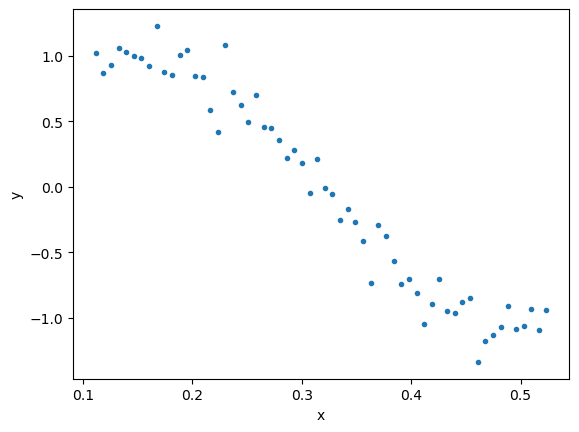

In [10]:
using PyPlot, CSV, DataFrames

data = CSV.read("lasso_data.csv", DataFrame)
x = data[:,1]
y = data[:,2]
plot(x, y, ".");
xlabel("x"); ylabel("y");
n=size(data, 1);

#### Part A

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
0, 38.919302, 6, 0.000248, 0.000000, 0, 0.000000, 0.000000
3, 1.015443, 6, 0.000321, 0.000000, 0, 0.000000, 1.000000
Model   status      : Optimal
QP ASM    iterations: 3
Objective value     :  1.0149939433e+00
HiGHS run time      :          0.00

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 5:-1:0
And data, a 6-element Vector{Float64}:
  19.066003136351615
  71.44235714899514
   3.3729137768712896
 -57.00331477955817
  15.626888602691789
  -0.1028384224726254

 The magnitudes of the coefficients are pretty large

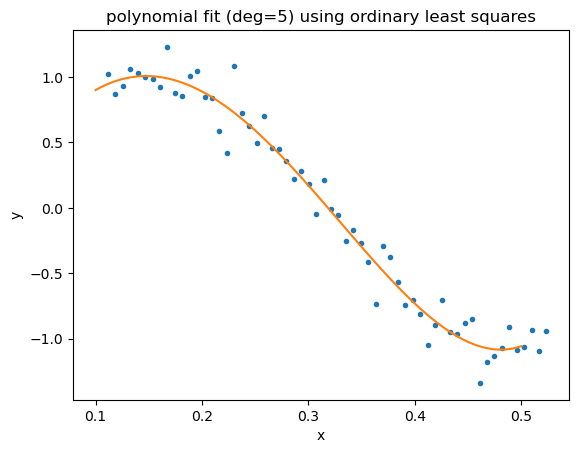

In [11]:
#d = 5
powers = reverse(0:5)

model = Model(HiGHS.Optimizer)
@variable(model, a[p in powers])
@objective(model, Min, sum( ((a[5]*x[i]^5 + a[4]*x[i]^4 + a[3]*x[i]^3 + a[2]*x[i]^2 +  a[1]*x[i]^1 + a[0]) - y[i])^2 for i in 1:length(x)) )
optimize!(model)
avals = value.(a)
    
# plot a line on top of it
f(x) = avals[5]*x^5 + avals[4]*x^4 + avals[3]*x^3 + avals[2]*x^2 + avals[1]*x + avals[0];

# points of the line
xs = range(0.1, 0.5, length=100);
ys = f.(xs)
#ys = zeros(length(xs));
#for (index, xval) in enumerate(xs)
#    ys[index] = avals[5]*xval^5 + avals[4]*xval^4 + avals[3]*xval^3 + avals[2]*xval^2 + avals[1]*xval + avals[0];
#end
        
# plot the scatters again
plot(x, y, ".");
# plot the line
plot(xs,ys,"-");
title(string("polynomial fit (deg=", 5, ") using ordinary least squares")); # it is not!
xlabel("x"); ylabel("y");
    
print("\n", avals)
print("\n\n The magnitudes of the coefficients are pretty large")

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
0, 38.919302, 16, 0.000240, 0.000000, 0, 0.000000, 0.000000
3, 1.014678, 16, 0.000368, 0.000000, 0, 0.000000, 1.000000
Model   status      : Optimal
QP ASM    iterations: 3
Objective value     :  1.0138753461e+00
HiGHS run time      :          0.00

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 15:-1:0
And data, a 16-element Vector{Float64}:
  -4.769709612904753
  -7.719218279995411
 -12.11595734906049
 -18.25698382786105
 -26.004801982239375
 -34.13220566435739
 -39.37024669227134
 -35.69141752251968
 -15.599497606166768
  23.138242444525158
  63.23737799536234
  59.083788240362395
 -16.588007305556953
 -45.7361841963497
  13.59173020644095
   0.016894208230994502

 The magnitudes of the coefficients are pretty large

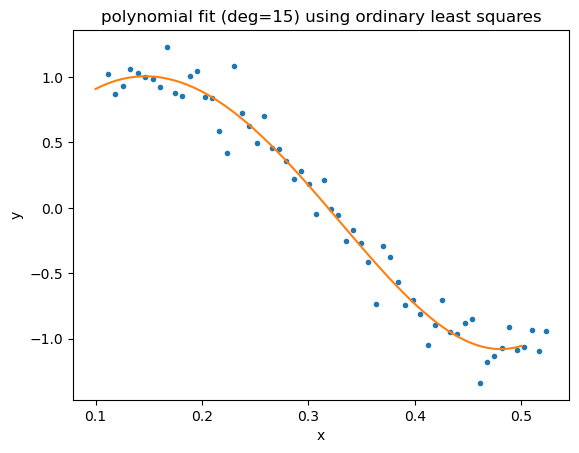

In [12]:
#d = 15
powers = reverse(0:15)

model = Model(HiGHS.Optimizer)
@variable(model, a[p in powers])
@objective(model, Min, sum( ((a[15]*x[i]^15 + a[14]*x[i]^14 + a[13]*x[i]^13 + a[12]*x[i]^12 +  a[11]*x[i]^11 + 
    a[10]*x[i]^10 + a[9]*x[i]^9 + a[8]*x[i]^8 + a[7]*x[i]^7 +  a[6]*x[i]^6 + 
    a[5]*x[i]^5 + a[4]*x[i]^4 + a[3]*x[i]^3 + a[2]*x[i]^2 +  a[1]*x[i]^1 + 
    a[0]) - y[i])^2 for i in 1:length(x)) )
optimize!(model)
avals = value.(a)
    
# plot a line on top of it
f(x) = avals[15]*x^15 + avals[14]*x^14 + avals[13]*x^13 + avals[12]*x^12 + avals[11]*x^11 +
    avals[10]*x^10 + avals[9]*x^9 + avals[8]*x^8 + avals[7]*x^7 + avals[6]*x^6 +
    avals[5]*x^5 + avals[4]*x^4 + avals[3]*x^3 + avals[2]*x^2 + avals[1]*x^1 +
    avals[0];

# points of the line
xs = range(0.1, 0.5, length=100);
ys = f.(xs)
#ys = zeros(length(xs));
#for (index, xval) in enumerate(xs)
#    ys[index] = avals[5]*xval^5 + avals[4]*xval^4 + avals[3]*xval^3 + avals[2]*xval^2 + avals[1]*xval + avals[0];
#end
        
# plot the scatters again
plot(x, y, ".");
# plot the line
plot(xs,ys,"-");
title(string("polynomial fit (deg=", 15, ") using ordinary least squares")); # it is not!
xlabel("x"); ylabel("y");
    
print("\n", avals)
print("\n\n The magnitudes of the coefficients are pretty large")

#### Part B

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
0, 38.919302, 16, 0.000243, 0.000000, 0, 0.000000, 0.000000
3, 1.022678, 16, 0.000382, 0.000000, 0, 0.000000, 1.000000
Model   status      : Optimal
QP ASM    iterations: 3
Objective value     :  1.0223298221e+00
HiGHS run time      :          0.00

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 15:-1:0
And data, a 16-element Vector{Float64}:
  -0.5466511379039996
  -0.8990027856281843
  -1.4328144801251572
  -2.1871394284432117
  -3.1356403871620304
  -4.069775728188712
  -4.386422591737866
  -2.7943454748022316
   2.847430563455945
  14.802674403810856
  32.09144577255167
  42.4803286009897
  15.599212801380883
 -58.01665335053112
  15.355125607096575
  -0.06728100908617267

 The magnitudes of the coefficients are significantly smaller than in the past non-LASSO regressions

 The fit of the graph to the points appears much the same, however

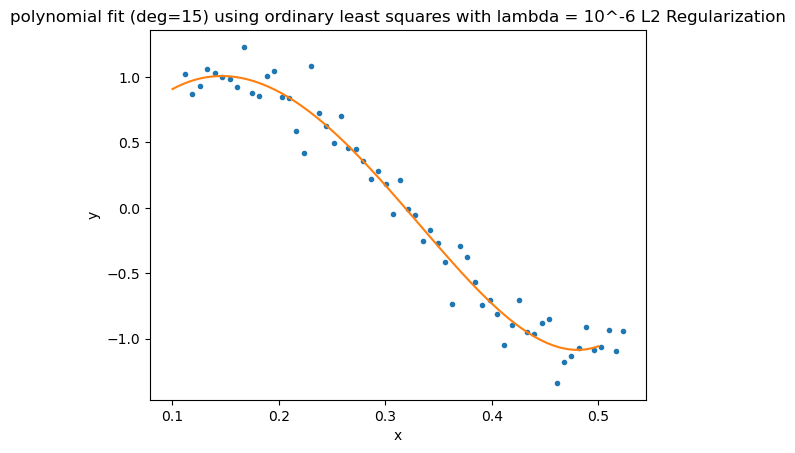

In [13]:
#d = 15
lambda = 10^(-6)
powers = reverse(0:15)

model = Model(HiGHS.Optimizer)
@variable(model, a[p in powers])
@objective(model, Min, sum( ((a[15]*x[i]^15 + a[14]*x[i]^14 + a[13]*x[i]^13 + a[12]*x[i]^12 +  a[11]*x[i]^11 + 
    a[10]*x[i]^10 + a[9]*x[i]^9 + a[8]*x[i]^8 + a[7]*x[i]^7 +  a[6]*x[i]^6 + 
    a[5]*x[i]^5 + a[4]*x[i]^4 + a[3]*x[i]^3 + a[2]*x[i]^2 +  a[1]*x[i]^1 + 
    a[0]) - y[i])^2 for i in 1:length(x)) + lambda*sum(a.^2) )
optimize!(model)
avals = value.(a)
    
# plot a line on top of it
f(x) = avals[15]*x^15 + avals[14]*x^14 + avals[13]*x^13 + avals[12]*x^12 + avals[11]*x^11 +
    avals[10]*x^10 + avals[9]*x^9 + avals[8]*x^8 + avals[7]*x^7 + avals[6]*x^6 +
    avals[5]*x^5 + avals[4]*x^4 + avals[3]*x^3 + avals[2]*x^2 + avals[1]*x^1 +
    avals[0];

# points of the line
xs = range(0.1, 0.5, length=100);
ys = f.(xs)
#ys = zeros(length(xs));
#for (index, xval) in enumerate(xs)
#    ys[index] = avals[5]*xval^5 + avals[4]*xval^4 + avals[3]*xval^3 + avals[2]*xval^2 + avals[1]*xval + avals[0];
#end
        
# plot the scatters again
plot(x, y, ".");
# plot the line
plot(xs,ys,"-");
title(string("polynomial fit (deg=", 15, ") using ordinary least squares with lambda = 10^-6 L2 Regularization")); # it is not!
xlabel("x"); ylabel("y");
    
print("\n", avals)
print("\n\n The magnitudes of the coefficients are significantly smaller than in the past non-LASSO regressions")
print("\n\n The fit of the graph to the points appears much the same, however")

#### Part C

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
0, 38.919302, 0, 0.000417, 0.000000, 0, 0.000000, 0.000000
23, 1.017270, 5, 0.000653, 0.000000, 1, 0.000000, 1.000000
Model   status      : Optimal
QP ASM    iterations: 23
Objective value     :  1.0150203804e+00
HiGHS run time      :          0.00

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 15:-1:0
And data, a 16-element Vector{Float64}:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
  19.627252414437937
  73.49427956455966
   0.0
 -55.32007623521861
  15.29165531368849
  -0.08033287895750861

 The magnitudes of the coefficients are significantly smaller than in the past non-LASSO regressions

 The fit of the graph to the points appears much the same, however

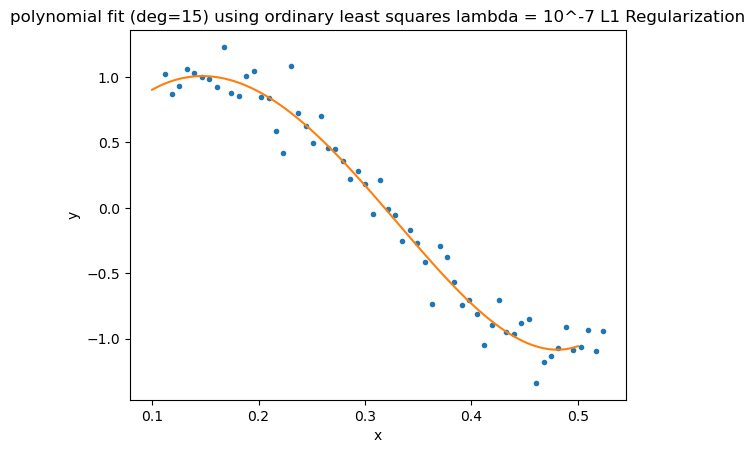

In [18]:
#d = 15
lambda = 10^(-7)
powers = reverse(0:15)

model = Model(HiGHS.Optimizer)
@variable(model, a[p in powers])
@variable(model, t[p in powers])
@variable(model, L1)
for p in powers
    @constraint(model, a[p] <= t[p] )
    @constraint(model, -t[p] <= a[p] )
end
@constraint(model, L1 == sum(t))
@objective(model, Min, sum( ((a[15]*x[i]^15 + a[14]*x[i]^14 + a[13]*x[i]^13 + a[12]*x[i]^12 +  a[11]*x[i]^11 + 
    a[10]*x[i]^10 + a[9]*x[i]^9 + a[8]*x[i]^8 + a[7]*x[i]^7 +  a[6]*x[i]^6 + 
    a[5]*x[i]^5 + a[4]*x[i]^4 + a[3]*x[i]^3 + a[2]*x[i]^2 +  a[1]*x[i]^1 + 
    a[0]) - y[i])^2 for i in 1:length(x)) + lambda*L1 )
optimize!(model)
avals = value.(a)
    
# plot a line on top of it
f(x) = avals[15]*x^15 + avals[14]*x^14 + avals[13]*x^13 + avals[12]*x^12 + avals[11]*x^11 +
    avals[10]*x^10 + avals[9]*x^9 + avals[8]*x^8 + avals[7]*x^7 + avals[6]*x^6 +
    avals[5]*x^5 + avals[4]*x^4 + avals[3]*x^3 + avals[2]*x^2 + avals[1]*x^1 +
    avals[0];

# points of the line
xs = range(0.1, 0.5, length=100);
ys = f.(xs)
#ys = zeros(length(xs));
#for (index, xval) in enumerate(xs)
#    ys[index] = avals[5]*xval^5 + avals[4]*xval^4 + avals[3]*xval^3 + avals[2]*xval^2 + avals[1]*xval + avals[0];
#end
        
# plot the scatters again
plot(x, y, ".");
# plot the line
plot(xs,ys,"-");
title(string("polynomial fit (deg=", 15, ") using ordinary least squares lambda = 10^-7 L1 Regularization")); # it is not!
xlabel("x"); ylabel("y");
    
print("\n", avals)
print("\n\n The magnitudes of the coefficients are significantly smaller than in the past non-LASSO regressions")
print("\n\n The fit of the graph to the points appears much the same, however")